In [1]:
!pip install https://github.com/qubvel/efficientnet/archive/master.zip

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     - 1.1MB 792kB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8zcy0fr/wheels/a3/5f/ae/7290259b5377e457435a6e1ca787c0675cd30d0357e66ed5c3
Successfully built efficientnet


In [2]:
!pip install scikit-image

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


In [6]:
!pip install --upgrade keras

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 317kB 56.6MB/s eta 0:00:01   | 204kB 56.6MB/s eta 0:00:01
     |████████████████████████████████| 51kB 67.7MB/s eta 0:00:01
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


In [7]:
!pip install numpy==1.15.0

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


In [ ]:
from modelarts.session import Session
session = Session()

session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

# 使用tar命令解压资源包
!tar xf ./image_recognition.tar.gz

# 清理压缩包
!rm -f ./image_recognition.tar.gz

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

import os,cv2,random
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard
import numpy as np
# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import keras
from keras.models import Model
from skimage.io import imread
from efficientnet import EfficientNetB5,preprocess_input
from keras import backend as K
K.set_image_data_format('channels_last')
%matplotlib inline
tf.__version__

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indi

'1.13.1'

In [2]:
DATA_DIR = './data/'
model_name = model_name = 'efficientnet-b5'
ckpt_dir = './efficientnet-b5/'
BATCH_SIZE = 32

In [3]:
ROWS = 224
COLS = 224
CHANNELS = 3
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)]

#dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
#cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float16)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        image = image - np.array(MEAN_RGB)
        image = image / np.array(STDDEV_RGB)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


In [4]:
labels = []
for i in image_file_names:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

labels = tf.keras.utils.to_categorical(labels, 2)

In [5]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

In [6]:
del images

In [7]:
del labels

In [8]:
del image_file_names

In [9]:
# loading pretrained model
basemodel = EfficientNetB5(input_shape=(224,224,3),weights='imagenet',include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
115302400/115295288 [==============================] - 322s 3us/step


In [10]:
basemodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [11]:
basemodel.trainable = True

set_trainable = False
for layer in basemodel.layers:
    if layer.name == 'multiply_39':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
x = basemodel.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
pred = keras.layers.Dense(2, activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model = Model(inputs=[basemodel.input],outputs=[pred])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
epochs=20
# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')   

def run_catdog():
    history = LossHistory()
    
    # 开始训练
    model.fit(
        train_data, 
        train_label, 
        batch_size=BATCH_SIZE, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=2,
        shuffle=True,
        callbacks=[history, early_stopping]) 
    
    return  history
history = run_catdog()

Instructions for updating:
Use tf.cast instead.
Train on 14062 samples, validate on 4688 samples
Epoch 1/20
 - 111s - loss: 0.4120 - acc: 0.8365 - val_loss: 0.1589 - val_acc: 0.9680
Epoch 2/20
 - 102s - loss: 0.2750 - acc: 0.8946 - val_loss: 0.1044 - val_acc: 0.9750
Epoch 3/20
 - 103s - loss: 0.2435 - acc: 0.9016 - val_loss: 0.0830 - val_acc: 0.9791
Epoch 4/20
 - 102s - loss: 0.2311 - acc: 0.9067 - val_loss: 0.0695 - val_acc: 0.9834
Epoch 5/20
 - 102s - loss: 0.2172 - acc: 0.9139 - val_loss: 0.0640 - val_acc: 0.9851
Epoch 6/20
 - 102s - loss: 0.2053 - acc: 0.9159 - val_loss: 0.0615 - val_acc: 0.9829
Epoch 7/20
 - 102s - loss: 0.2002 - acc: 0.9175 - val_loss: 0.0562 - val_acc: 0.9853
Epoch 8/20
 - 101s - loss: 0.1945 - acc: 0.9193 - val_loss: 0.0531 - val_acc: 0.9859
Epoch 9/20
 - 101s - loss: 0.1963 - acc: 0.9177 - val_loss: 0.0523 - val_acc: 0.9846
Epoch 10/20
 - 101s - loss: 0.1903 - acc: 0.9212 - val_loss: 0.0508 - val_acc: 0.9857
Epoch 11/20
 - 101s - loss: 0.1860 - acc: 0.9269 - v

In [17]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'b5.h5'))

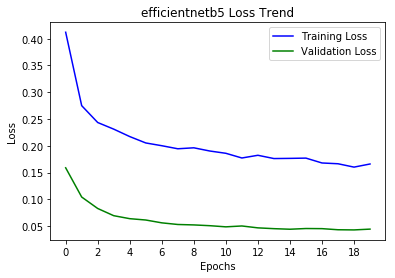

In [18]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('efficientnetb5 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

In [19]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
# 评估模型准确度
predictions_test = []
test_label_test = []
for p in predictions:

    if int(round(p[0])) == 1:
        predictions_test.append(1)
    else:
        predictions_test.append(0)
for t in test_label:
    if int(t[0]) == 1:
        test_label_test.append(1)
    else:
        test_label_test.append(0)
acc = accuracy_score(test_label_test, predictions_test)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.985280
